# Uncapacitated Facility Location Problem
## Setup

In [216]:
# autoreload external files
%reload_ext autoreload
%autoreload 2

# import custom lib
from solver_utils import *
from data_utils import *
import benchmark as bnc
#from plot import *

# import lib
from pulp import *
import numpy as np
print('numpy:', np.__version__)
import pandas as pd
print('pandas:', pd.__version__)
import seaborn as sns
print('seaborn:',sns.__version__)
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
print('matplotlib:',matplotlib.__version__)
import timeit as time


# services
Data = DataGenerator()

numpy: 1.15.2
pandas: 0.23.4
seaborn: 0.9.0
matplotlib: 2.2.2


## Primal Model

In [217]:
def build_primal(c_num, l_num, C, F):
    # problem instance
    problem = LpProblem("UFL - Primal Problem (Wolsey)", sense=LpMaximize)

    # decision variables
    x = Data.VAR_matrix(c_num, l_num, 'x', 'Continuous')
    y = Data.VAR_vector(l_num, 'y', 'Binary')

    # objective function
    profits = [C[i][j] * x[i][j] for i in range(c_num) for j in range(l_num)]
    fixed_costs = [F[j] * y[j] for j in range(l_num)]
    problem += lpSum(profits) - lpSum(fixed_costs)

    # constraints
    for i in range(c_num):
        problem += lpSum([x[i][j] for j in range(l_num)]) == 1

    for i in range(c_num):
        for j in range(l_num):
            problem += x[i][j] - y[j] <= 0
            
    return problem

## Integer Problem

In [218]:
def build_primal_int(c_num, l_num, C, F):
    # problem instance
    problem = LpProblem("UFL - Primal Integer Relaxed Problem (Wolsey)", sense=LpMaximize)

    # decision variables
    x = Data.VAR_matrix(c_num, l_num, 'x', 'Continuous')
    y = Data.VAR_vector(l_num, 'y', 'Continuous')

    # objective function
    profits = [C[i][j] * x[i][j] for i in range(c_num) for j in range(l_num)]
    fixed_costs = [F[j] * y[j] for j in range(l_num)]
    problem += lpSum(profits) - lpSum(fixed_costs)

    # constraints
    for i in range(c_num):
        problem += lpSum([x[i][j] for j in range(l_num)]) == 1

    for i in range(c_num):
        for j in range(l_num):
            problem += x[i][j] - y[j] <= 0
            
    return problem

## Lagrangian Relaxed Model

In [219]:
def build_relaxed(c_num, l_num, u_vector, C, F):
    """
    Lagrange relaxation for UFL problem as in Wolsey
    """

    # problem instance
    problem = LpProblem("UFL - Lagrange Relaxed Problem (Wolsey)", sense=LpMaximize)

    # check lagrange multipliers vector
    if len(u_vector) != c_num : 
        raise ValueError('Invalid u_vect size')

    # decision variables    
    x = Data.VAR_matrix(c_num, l_num, 'x', 'Continuous')
    y = Data.VAR_vector(l_num, 'y', 'Binary')

    # objective function
    profits = [C[i][j] * x[i][j] for i in range(c_num) for j in range(l_num)]
    fixed_costs = [F[j] * y[j] for j in range(l_num)]
    l1 = [u_vector[i] for i in range(c_num)]
    l2 = [u_vector[i] * x[i][j] for i in range(c_num) for j in range(l_num)]
    #lagrange = [u_vector[i] * (1 - x[i][j]) for i in range(c_num) for j in range(l_num)]

    problem += lpSum(profits) - lpSum(fixed_costs) + lpSum(l1) - lpSum(l2)

    # constraints
    for i in range(c_num):
        for j in range(l_num):
            problem += x[i][j] - y[j] <= 0

    return problem

## Subgradient Algorithm

## Results

### Initialize benchmark environment

In [220]:
def init_benchmark_env():
    # params
    c_shapes = [(c,5) for c in range(10,50,10)]
    l_shapes = [(50,l) for l in range(2,10,2)]
    i_shapes = c_shapes + l_shapes #instance sizes
    i_rep = 10 #instances for each size
    
    i_shapes = [(10,3), (15,5)]
    i_rep = 3
    
    # init data
    b = bnc.Benchmark()
    i = b.build_test_instances(i_shapes, i_rep)    
    """
    # save instances
    for idx, instance in enumerate(i):
        b.save(instance, idx)  
        
    # load instances
    i = b.load()
    """
    # return instances
    return i
    

### Run benchmark

In [221]:
def runner():
    # init benchmark instances
    instances = init_benchmark_env()
    results = list()    
    # run instances
    for i in instances:        
        # init benchmark data
        b_data = bnc.BenchmarkResult_v2(i)
        results.append(b_data)
        
        # compute cost/profits
        #delta_cp = [np.sum(i.C[:,k]) - i.F[k] for k in range(i.l_num)]
        #print(u"Δ_cp =",delta_cp, end='\n\n\n')  
        
        # solve primal
        time.timeit()
        b_data = solve_primal(b_data)
        
        # solve integer relaxed        
        b_data = solve_relaxed(b_data)
        
        # solve lagrangian dual        
        b_data = solve_lagrangian(b_data)        
        
    return results

### Plot results

In [222]:
sns.set(style="whitegrid", palette="Set2")
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['font.size'] = 10
#cmap = sns.diverging_palette(10, 220, sep=80, n=7, as_cmap=True)
cmap = sns.color_palette("Set2")


def plot_clients_demand_alloc(benchmark):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,sharey=True)    
    fig.suptitle('Clients Demand Allocation', fontsize=20)
    ax1.set_title("Primal")
    ax1.set_ylabel('Clients')
    ax2.set_title("Integer relaxed") 
    ax3.set_title("Lagrange relaxed")    
    
    sns.heatmap(benchmark.X_ip,ax=ax1,cbar=False,center=0.5,cmap=cmap,annot=True,fmt=".1f",linewidths=0.5)
    sns.heatmap(benchmark.X_int,ax=ax2,cbar=False,center=0.5,cmap=cmap,annot=True,fmt=".1f",linewidths=0.5)
    sns.heatmap(benchmark.X_lag,ax=ax3,cbar=False,center=0.5,cmap=cmap,annot=True,fmt=".1f",linewidths=0.5)
    
    ax1.set_ylabel('client')
    ax1.set_xlabel('warehouse')
    ax2.set_xlabel('warehouse')
    ax3.set_xlabel('warehouse')
    plt.show()
    
    
def plot_warehouse_alloc(benchmark):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3)    
    fig.suptitle('Warehouse Allocation', fontsize=20)
    ax1.set_title("Primal")
    ax1.set_ylabel('Clients')
    ax2.set_title("Integer relaxed") 
    ax3.set_title("Lagrange relaxed")    
    
    data = [benchmark.Y_ip, benchmark.Y_int, benchmark.Y_lag]
    sns.heatmap([data[0]], ax=ax1, cbar=False, cmap=cmap, annot=True, fmt=".1f", linewidths=0.5, xticklabels=False, yticklabels=False)
    sns.heatmap([data[1]], ax=ax2, cbar=False, cmap=cmap, annot=True, fmt=".1f", linewidths=0.5, xticklabels=False, yticklabels=False)
    sns.heatmap([data[2]], ax=ax3, cbar=False, cmap=cmap, annot=True, fmt=".1f", linewidths=0.5, xticklabels=False, yticklabels=False)
    
    ax1.set_xlabel('warehouse')
    ax2.set_xlabel('warehouse')
    ax3.set_xlabel('warehouse')
    plt.show()
    
    
    
def plot_subgradient(benchmark): 
    fig, ax1 = plt.subplots(1)
    fig.suptitle('Subgradient Process', fontsize=20)
    
    ax1.set_ylabel('z value')    
    ax1.set_xlabel('iteration')    
    
    # get data   
    subg = np.array(benchmark.SubgradientData['z'])
    primal = np.array([benchmark.Z_ip for i in range(len(subg))])
    int_rel = np.array([benchmark.Z_int for i in range(len(subg))])
    data = [subg, primal]
    
    # plot
    line1 = ax1.plot(subg)
    line3 = ax1.plot(int_rel)
    line2 = ax1.plot(primal, linewidth=1, linestyle='--')
    ax1.legend(('subgradient','integer relaxed','primal'),loc='best')
    
    plt.show()    
    
    
def sinplot(flip=1):
    x = np.linspace(0, 14, 100)
    for i in range(1, 7):
        plt.plot(x, np.sin(x + i * .5) * (7 - i) * flip)
    plt.show()
        
        
def plot_data(results):
    for r in results:        
        plot_clients_demand_alloc(r)
        #plot_warehouse_alloc(r)
        plot_subgradient(r)
        
        
#plot_data(Results)

In [223]:
b = bnc.Benchmark()
results = runner()

####################
SOLVE PRIMAL
Z = 16.0
Time = 0.06
####################
SOLVE INTEGER RELAXED
Z = 16.000000000045006
Time = 0.08
####################
SOLVE LAGRANGE DUAL
z_best: 32.0
z_best: 16.529411764705927
z_best: 16.000000000000007
Z = 16.000000000000007
Time = 3.62
####################
SOLVE PRIMAL
Z = -2.0
Time = 0.05
####################
SOLVE INTEGER RELAXED
Z = -1.9999999998609965
Time = 0.04
####################
SOLVE LAGRANGE DUAL
z_best: 0.0
z_best: -1.9999999999999996
Z = -1.9999999999999996
Time = 3.6
####################
SOLVE PRIMAL
Z = 7.0
Time = 0.05
####################
SOLVE INTEGER RELAXED
Z = 7.000000000116991
Time = 0.04
####################
SOLVE LAGRANGE DUAL
z_best: 12.0
z_best: 8.419354838709666
z_best: 7.499999999999993
Z = 7.499999999999993
Time = 3.64
####################
SOLVE PRIMAL
Z = 33.0
Time = 0.06
####################
SOLVE INTEGER RELAXED
Z = 33.00000000060298
Time = 0.06
####################
SOLVE LAGRANGE DUAL
z_best: 71.0
z_best: 46.077844

   dimension  integer_time  relaxed_time  lagrange_time
0         40          0.06          0.08           3.62
1         40          0.05          0.04           3.60
2         40          0.05          0.04           3.64
3         90          0.06          0.06           7.55
4         90          0.05          0.04           6.50
5         90          0.05          0.04           6.48


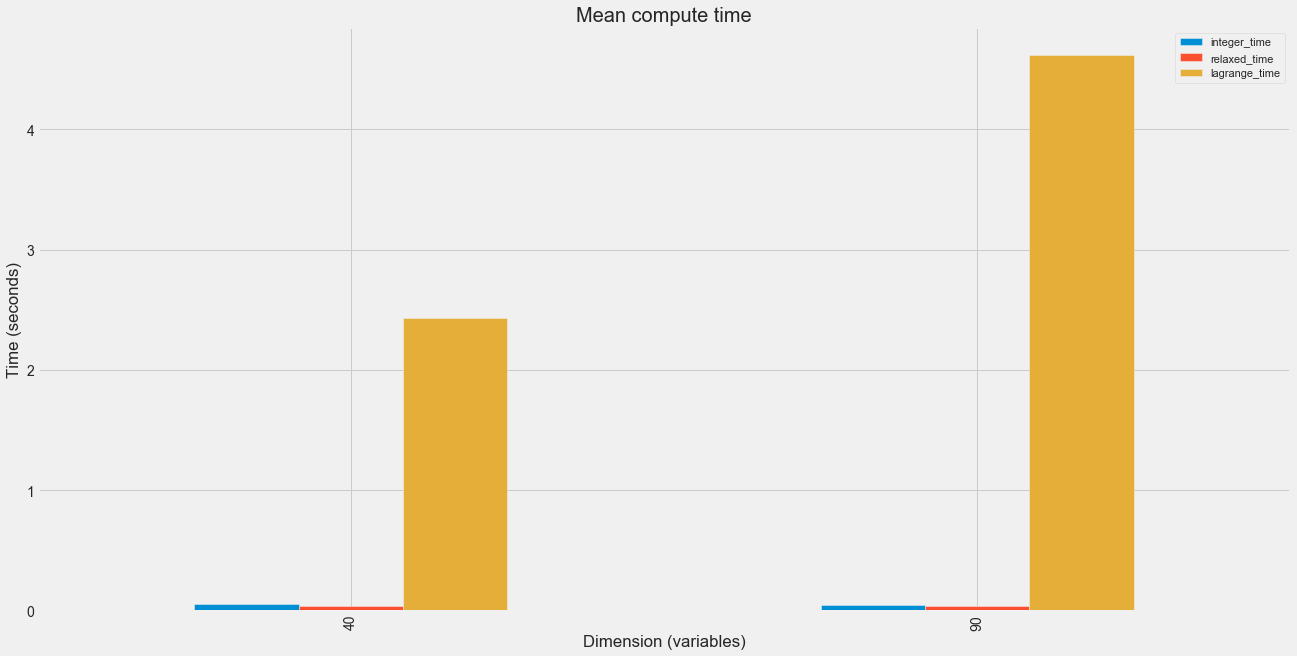

In [226]:
# plot custom settings
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(1)
plt.rc('axes', labelsize=16, titlesize=20)
plt.rc(('xtick', 'ytick'), labelsize=14)

# select data
df = b.to_dataframe(results)
df_time = df.loc[:,['dimension','integer_time','relaxed_time','lagrange_time']]
print(df_time)
df_time = df_r.groupby(['dimension'], sort=False).mean()

# plot
df_time.plot(kind='bar', ax=ax)
ax.set_title('Mean compute time')
plt.ylabel('Time (seconds)')
plt.xlabel('Dimension (variables)')
plt.legend()

   integer_z                                               sg_z
0       16.0  [32.0, 16.529411764705927, 16.000000000000007,...
1       -2.0  [0.0, -1.9999999999999996, -1.9999999999999998...
2        7.0  [12.0, 8.419354838709666, 7.499999999999993, 7...
3       33.0  [71.0, 46.07784431137722, 37.99999999999997, 3...
4        7.0  [18.0, 7.4313725490196205, 7.4313725490196205,...
5       18.0  [25.0, 19.07692307692306, 19.07692307692306, 1...


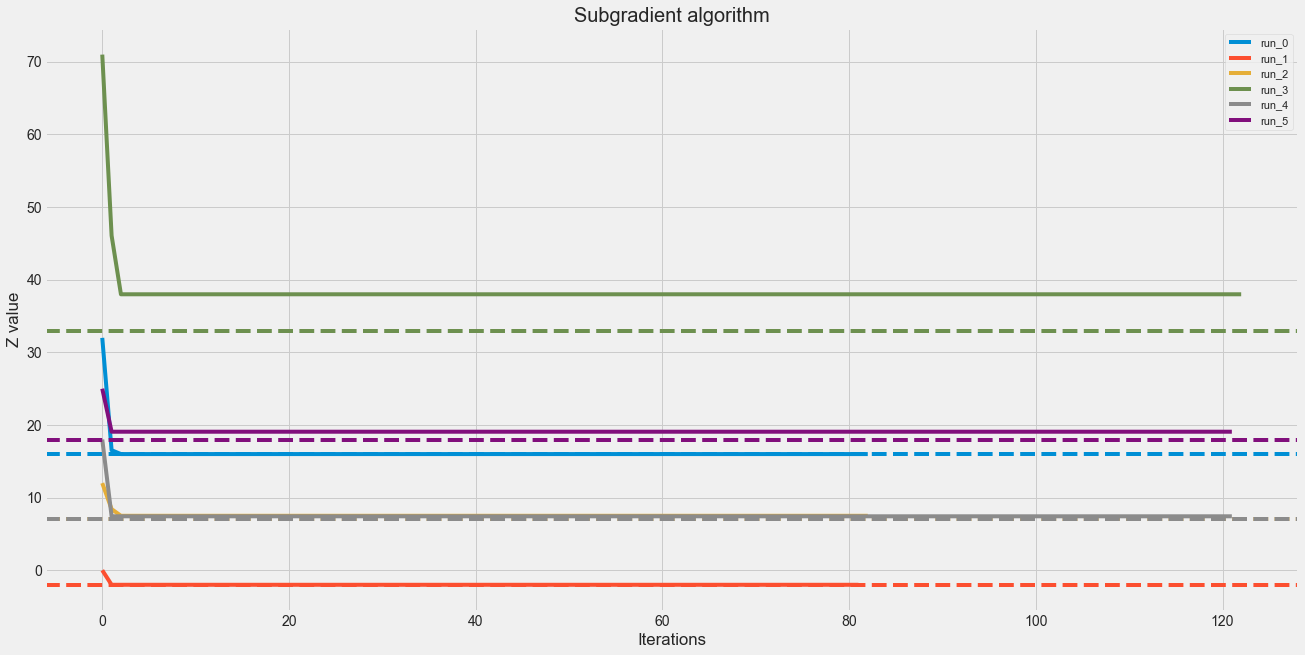

In [227]:
# select data
df = b.to_dataframe(results)
df_sg = df.loc[:,['integer_z','sg_z']]
print(df_sg)

y_data = df_sg.values;

# plot
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(1)
plt.rc('axes', labelsize=16, titlesize=20)
plt.rc(('xtick', 'ytick'), labelsize=14)

ax.set_title('Subgradient algorithm')
plt.ylabel('Z value')
plt.xlabel('Iterations')

for idx, val in enumerate(y_data):
    p = plt.plot(val[1], label='run_{}'.format(idx))
    plt.axhline(val[0],color=p[0].get_color(), ls='--')
plt.legend()